In [57]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns
from tqdm import tqdm


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [58]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [59]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest - possible feature combinations

In [61]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "gdp+unempl",
    "19+gdp+unempl",
    "ar",
    "ar+19",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

lags = [
    [1],
    [3],
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False, False, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16],
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=ensemble.RandomForestRegressor(random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 9/9 [03:04<00:00, 20.53s/it]


In [62]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,randomforestregressor__max_features,randomforestregressor__min_samples_leaf,randomforestregressor__min_samples_split
19,sqrt,1,4
gdp+unempl,sqrt,1,4
19+gdp+unempl,sqrt,1,8
ar,sqrt,8,2
ar+19,auto,2,16
ar+gdp+unempl,sqrt,2,16
ar+19+gdp+unempl,sqrt,1,4


In [63]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                     mean    std      sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw             0.003   0.002  5.561e-04    0.005    1.843e-03  6.514e-04  -0.066   0.011  0.004   -0.098   0.023  0.008           0.349          0.229  0.081     0.449    0.282  0.100      0.051      0.067  0.024
bench-rw-realistic   0.003   0.001  4.742e-04    0.004    4.370e-04  1.545e-04  -0.104   0.033  0.012   -0.148   0.054  0.019          -0.183          0.353  0.125    -0.086    0.481  0.170      0.014      0.045  0.016
19                   0.254   0.042  1.491e-02    0.028    1.390e-02  4.916e-03  -0.084   0.029  0.010   -0.125   0.048  0.017           0.128          0.267  0.094     0.227    0.363  0.128      0.033      0.046  0.016
gdp+unempl           0.161   0.013  4.507e-03    0.014    7.052e-04  2.493e-04  -0.094   0.035  0.012   -0.126   0.049  0.017           0.128          0.163  0.057     0.246    0.258  0.091      0.023      0.043  0.015
19+gdp+unempl        0.179   0.034  1.203e-02    0.015    2.848e-03  1.007e-03  -0.083   0.026  0.009   -0.117   0.043  0.015           0.208          0.168  0.060     0.321    0.271  0.096      0.035      0.049  0.017
ar                   0.126   0.012  4.329e-03    0.015    1.144e-03  4.045e-04  -0.103   0.048  0.017   -0.143   0.067  0.024           0.076          0.175  0.062     0.093    0.292  0.103      0.015      0.032  0.011
ar+19                0.482   0.053  1.880e-02    0.023    4.555e-03  1.610e-03  -0.085   0.026  0.009   -0.123   0.041  0.015           0.116          0.270  0.095     0.200    0.410  0.145      0.032      0.049  0.017
ar+gdp+unempl        0.220   0.054  1.904e-02    0.019    2.475e-03  8.751e-04  -0.091   0.034  0.012   -0.125   0.052  0.018           0.185          0.112  0.040     0.276    0.232  0.082      0.026      0.044  0.015
ar+19+gdp+unempl     0.274   0.151  5.327e-02    0.020    1.285e-02  4.543e-03  -0.081   0.025  0.009   -0.115   0.042  0.015           0.248          0.155  0.055     0.336    0.277  0.098      0.036      0.050  0.018

In [64]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
bench-rw,-0.090,-0.142,0.624,0.658,0.052
19,-0.109,-0.191,0.351,0.382,0.033
ar+19,-0.109,-0.192,0.308,0.372,0.033
ar+19+gdp+unempl,-0.122,-0.199,0.246,0.327,0.020
19+gdp+unempl,-0.127,-0.201,0.235,0.316,0.015
ar,-0.122,-0.207,0.189,0.275,0.020
ar+gdp+unempl,-0.143,-0.217,0.119,0.200,-0.001
gdp+unempl,-0.155,-0.229,0.029,0.107,-0.013
bench-rw-realistic,-0.148,-0.249,-0.120,-0.051,-0.006


#### Performance by year (CV+test)

In [92]:
comp_models = ["bench-rw", "bench-rw-realistic", "19", "19+gdp+unempl", "ar+gdp+unempl"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["rmse", "r2_mod", "mae", "delta_mae"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
    )
    if m=="r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()

IndexError: list index out of range

#### Performance by country

##### prepare dummy scores (realistic)

In [66]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[1], train_unstackeds[1], cv_default)

##### best model without AR lags: KW19 + econ

test scores

In [67]:
i = model_names.index("19+gdp+unempl")


In [68]:

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae,rmse_vs_dummy
IT,-0.027,-0.039,0.717,0.967,0.178,7.686e-02
CZ+SK,-0.038,-0.044,0.062,0.733,0.033,1.991e-02
FR,-0.023,-0.029,-0.306,0.621,0.020,1.053e-02
LV+LT+EE,-0.067,-0.069,0.389,0.595,0.039,-3.778e-02
HU,-0.060,-0.065,0.469,0.490,0.021,8.276e-02
HR,-0.437,-0.588,0.025,0.484,0.246,2.665e-01
BG,-0.213,-0.222,0.042,0.378,0.061,5.326e-03
RO,-0.275,-0.288,0.004,0.371,0.078,-4.759e-02
PL,-0.061,-0.063,0.274,0.141,-0.006,5.366e-02
SE+FI+DK,-0.046,-0.059,0.083,0.070,0.002,2.343e-03


CV scores

In [69]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=True)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod               delta_mae                  
          0.25   0.50   0.75   0.25   0.50   0.75         0.25         0.50   0.75   0.25   0.50   0.75     0.25      0.50     0.75 
HR        0.073  0.149  0.168  0.086  0.173  0.189       -0.574       -0.128  0.324 -0.053  0.290  0.440   -0.003   3.841e-02  0.055
SI        0.078  0.135  0.210  0.113  0.158  0.247       -0.178       -0.098  0.025  0.112  0.340  0.560    0.024   3.639e-02  0.093
GR        0.065  0.101  0.169  0.094  0.113  0.191       -0.340       -0.235  0.034 -0.883 -0.251  0.455   -0.016  -8.340e-03  0.079
ES        0.058  0.098  0.113  0.059  0.107  0.121       -0.085        0.043  0.306  0.356  0.647  0.797    0.036   5.700e-02  0.151
RO        0.069  0.091  0.098  0.081  0.097  0.111       -1.048       -0.161  0.088 -0.662  0.095  0.572   -0.013   1.807e-02  0.060
PT        0.062  0.082  0.101  0.068  0.094  0.115       -0.342       -0.150 -0.065  0.220  0.359  0.784    0.007   2.280e-02  0.090
LV+LT+EE  0.056  0.079  0.123  0.060  0.087  0.127       -0.283        0.277  0.419 -0.259 -0.015  0.387   -0.015  -6.591e-03  0.013
HU        0.047  0.070  0.167  0.058  0.078  0.195       -0.677       -0.410 -0.005  0.285  0.545  0.651    0.021   3.696e-02  0.054
IE        0.045  0.065  0.087  0.052  0.074  0.091       -0.285        0.113  0.147 -0.298  0.076  0.294   -0.014   3.313e-04  0.011
CZ+SK     0.038  0.058  0.102  0.049  0.068  0.131       -0.133        0.131  0.280  0.068  0.429  0.494    0.003   2.166e-02  0.042
GB        0.036  0.055  0.068  0.048  0.066  0.081       -1.395       -0.450  0.086  0.010  0.094  0.291    0.005   8.491e-03  0.013
PL        0.027  0.056  0.100  0.032  0.065  0.118       -0.237        0.043  0.399  0.266  0.544  0.786    0.016   2.442e-02  0.036
BG        0.043  0.053  0.077  0.049  0.057  0.080       -0.701        0.097  0.601 -0.674  0.077  0.732   -0.016  -1.045e-03  0.027
IT        0.037  0.045  0.099  0.042  0.052  0.109       -0.183        0.097  0.272  0.363  0.453  0.553    0.011   2.801e-02  0.077
FR        0.026  0.037  0.045  0.030  0.046  0.055       -1.408       -0.415  0.013 -0.603 -0.012  0.410   -0.007   2.677e-03  0.018
AT+CH     0.030  0.042  0.091  0.032  0.045  0.108       -0.797       -0.123  0.093 -0.818  0.100  0.476   -0.025  -4.367e-03  0.006
BE+NL+LU  0.027  0.034  0.059  0.032  0.044  0.067       -0.322       -0.202 -0.097 -0.426 -0.173  0.261   -0.004  -1.132e-03  0.006
SE+FI+DK  0.029  0.037  0.045  0.033  0.040  0.055       -0.265       -0.046  0.201 -0.481  0.127  0.285   -0.007  -7.178e-04  0.003

plot RMSE absolute

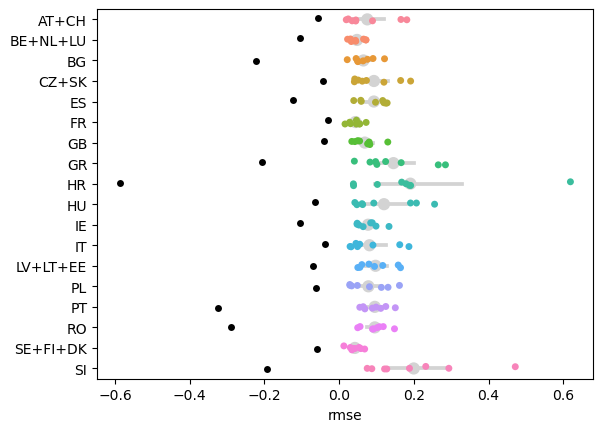

In [70]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

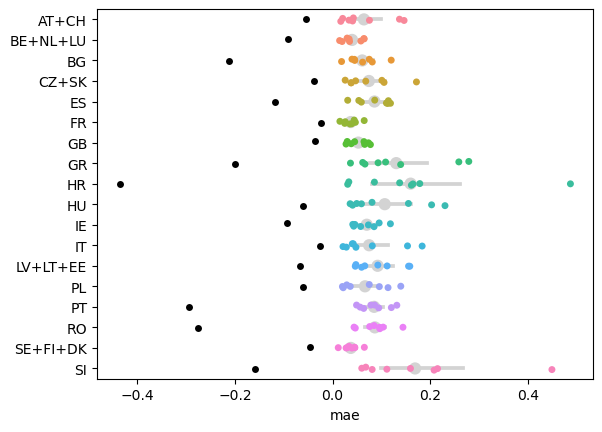

In [71]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

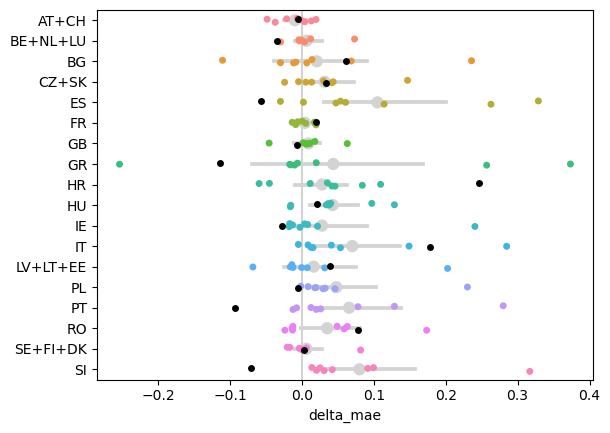

In [72]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.show()


##### best model with AR lags: value + KW19 + econ

test scores

In [73]:
i = model_names.index("ar+19+gdp+unempl")


In [74]:

test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse_vs_dummy"] = test_scores_c["rmse"] - test_scores_c_dummy["rmse"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae,rmse_vs_dummy
IT,-0.028,-0.045,0.678,0.956,0.177,0.071
CZ+SK,-0.019,-0.027,0.670,0.902,0.053,0.037
FR,-0.019,-0.021,0.444,0.807,0.024,0.019
LV+LT+EE,-0.044,-0.052,-0.324,0.775,0.062,-0.020
AT+CH,-0.028,-0.035,0.025,0.566,0.021,0.014
GB,-0.021,-0.024,0.205,0.520,0.007,0.016
HR,-0.423,-0.577,0.046,0.503,0.260,0.278
HU,-0.062,-0.068,0.414,0.440,0.020,0.080
RO,-0.257,-0.274,-0.264,0.432,0.097,-0.033
BG,-0.226,-0.235,-0.018,0.303,0.048,-0.008


CV scores

In [75]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=True)
display(cv_scores_c_agg.sort_values(by=("rmse", 0.5), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod                   delta_mae                   
          0.25   0.50   0.75   0.25   0.50   0.75         0.25         0.50   0.75   0.25     0.50     0.75     0.25       0.50     0.75 
HR        0.091  0.152  0.182  0.117  0.176  0.189       -0.513       -0.152  0.167 -1.240  1.642e-01  0.353 -3.453e-02  2.937e-02  0.051
SI        0.086  0.127  0.216  0.113  0.148  0.253       -0.219       -0.065  0.042  0.201  4.386e-01  0.596  1.966e-02  4.135e-02  0.091
GR        0.070  0.100  0.154  0.091  0.121  0.164       -0.456       -0.255 -0.047 -1.071 -4.502e-01  0.425 -2.324e-02 -9.478e-03  0.083
ES        0.077  0.097  0.113  0.079  0.113  0.122       -0.025        0.336  0.519  0.349  6.733e-01  0.841  4.293e-02  6.362e-02  0.164
LV+LT+EE  0.059  0.082  0.116  0.068  0.097  0.121        0.054        0.374  0.594 -0.397 -7.074e-02  0.369 -1.319e-02  3.052e-04  0.022
HU        0.041  0.068  0.135  0.048  0.083  0.162       -0.801        0.121  0.190  0.400  6.266e-01  0.755  3.035e-02  4.416e-02  0.071
PT        0.052  0.072  0.086  0.063  0.082  0.098        0.058        0.167  0.283  0.294  4.533e-01  0.888  6.698e-03  3.011e-02  0.110
IE        0.059  0.071  0.095  0.067  0.078  0.100       -0.799       -0.471  0.271 -0.485  6.296e-02  0.431 -1.299e-02  3.430e-03  0.014
RO        0.057  0.061  0.095  0.064  0.074  0.102       -0.147        0.244  0.475 -0.543  2.266e-01  0.840 -1.329e-02  3.967e-02  0.081
PL        0.033  0.061  0.110  0.040  0.071  0.127       -0.525        0.016  0.274  0.239  5.027e-01  0.774  6.820e-03  2.018e-02  0.035
CZ+SK     0.038  0.058  0.099  0.044  0.069  0.130       -0.289        0.133  0.266  0.036  3.832e-01  0.555  4.338e-03  1.821e-02  0.040
IT        0.034  0.056  0.106  0.036  0.064  0.114       -0.214        0.196  0.520  0.180  5.278e-01  0.692  1.065e-02  2.391e-02  0.092
BG        0.038  0.052  0.085  0.048  0.061  0.086       -0.436       -0.130  0.383 -0.813  5.020e-04  0.344 -1.360e-02  6.032e-04  0.021
GB        0.027  0.050  0.061  0.040  0.060  0.073       -0.378        0.008  0.102  0.267  4.403e-01  0.551  9.374e-03  1.679e-02  0.021
BE+NL+LU  0.026  0.041  0.057  0.031  0.050  0.062       -0.191        0.129  0.457 -0.580 -5.100e-02  0.240 -4.280e-03 -7.096e-04  0.001
SE+FI+DK  0.024  0.039  0.042  0.034  0.046  0.052       -0.030        0.124  0.253 -0.336  1.660e-01  0.236 -8.451e-03  7.163e-04  0.007
AT+CH     0.034  0.037  0.069  0.035  0.041  0.094       -0.989       -0.194  0.003 -0.881  3.909e-02  0.517 -2.324e-02 -5.099e-03  0.008
FR        0.029  0.035  0.041  0.036  0.040  0.049       -0.808       -0.230  0.195 -0.105  8.438e-02  0.310  6.302e-04  6.531e-03  0.011

plot RMSE absolute

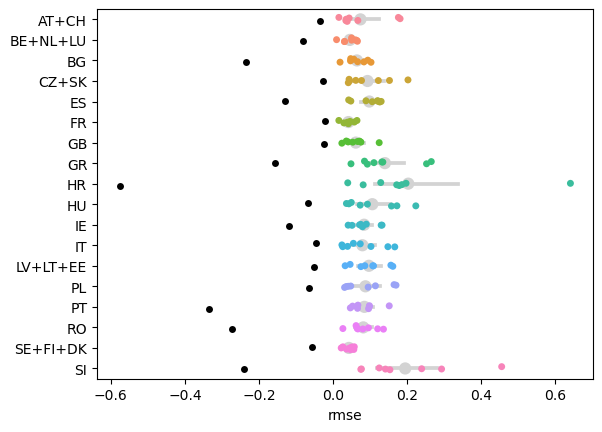

In [76]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

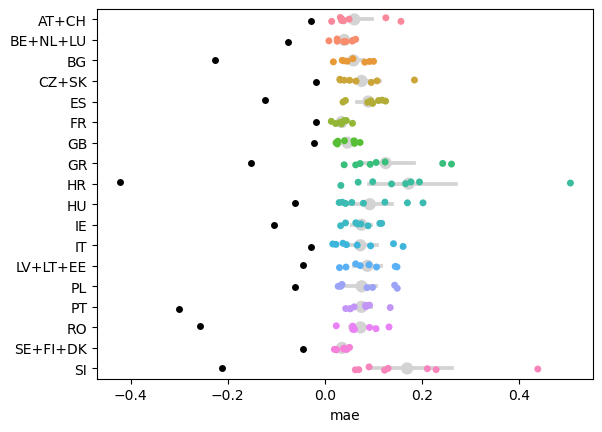

In [77]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

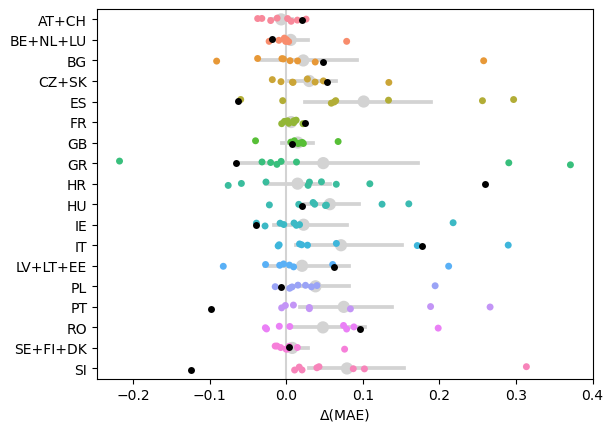

In [78]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [79]:
i1 = model_names.index("19+gdp+unempl")
i2 = model_names.index("gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

cv_diff_agg["rmse"]

,mean,std,sem
AT+CH,1.734e-02,0.021,0.007
BE+NL+LU,2.964e-02,0.042,0.015
BG,2.323e-02,0.035,0.012
CZ+SK,1.821e-04,0.012,0.004
ES,6.453e-02,0.055,0.019
FR,2.661e-03,0.012,0.004
GB,1.339e-03,0.017,0.006
GR,2.133e-02,0.027,0.010
HR,2.082e-02,0.031,0.011
HU,1.020e-03,0.033,0.012


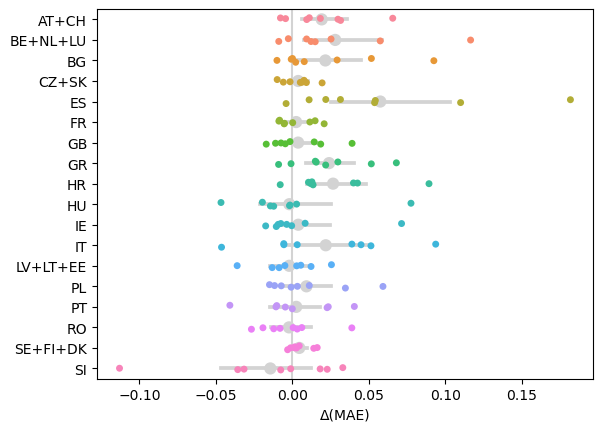

In [80]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
# sns.boxenplot(
#     data=cv_diff.reset_index(),
#     y="level_0",
#     x="mae",
#     # linestyles="",
#     # color="lightgrey",
#     # linewidth=0.0
# )
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


##### with own lags

In [81]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0,)

cv_diff_agg["rmse"]

,mean,std,sem
AT+CH,8.932e-03,0.020,0.007
BE+NL+LU,1.707e-02,0.028,0.010
BG,1.418e-02,0.029,0.010
CZ+SK,1.696e-02,0.024,0.009
ES,4.789e-02,0.038,0.013
FR,1.619e-03,0.006,0.002
GB,-1.418e-03,0.006,0.002
GR,3.003e-02,0.051,0.018
HR,-7.123e-03,0.020,0.007
HU,1.313e-02,0.033,0.012


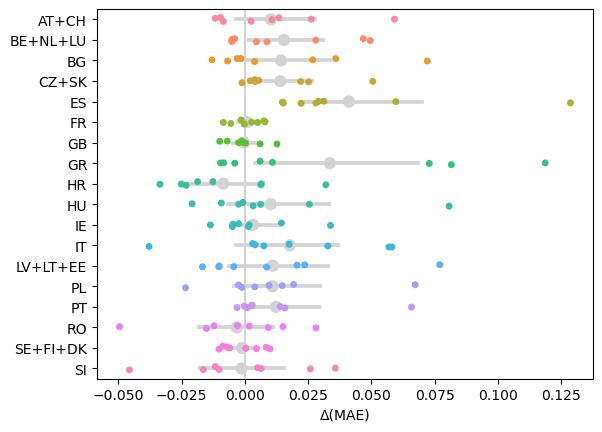

In [82]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### feature importance

In [83]:
i = model_names.index("19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_1                1.196e-01
unempl_6            1.004e-01
19_2                9.567e-02
unempl_5            8.908e-02
19_3                7.338e-02
unempl_4            7.315e-02
unempl_3            6.670e-02
unempl_2            6.499e-02
19_5                4.266e-02
19_4                3.986e-02
19_6                3.968e-02
gdp_2               3.565e-02
gdp_3               2.857e-02
gdp_6               2.836e-02
gdp_4               2.626e-02
gdp_5               2.307e-02
country_SI          1.067e-02
country_HR          9.968e-03
country_HU          5.197e-03
country_GR          4.920e-03
country_RO          4.843e-03
country_ES          4.796e-03
country_CZ+SK       2.042e-03
country_IE          1.642e-03
country_PL          1.288e-03
country_AT+CH       1.205e-03
country_IT          1.199e-03
country_PT          1.106e-03
country_LV+LT+EE    1.071e-03
country_BG          9.832e-04
country_GB          7.533e-04
country_BE+NL+LU    5.382e-04
country_FR          4.316e-04
country_SE

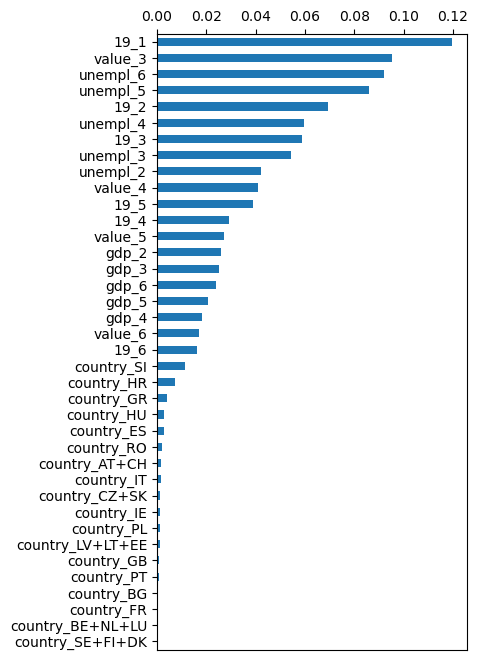

In [84]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
plt.figure(figsize=(4,8))
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=True
).plot(kind="barh")
plt.gca().xaxis.tick_top()
plt.show()

#### Plot prediction

all features

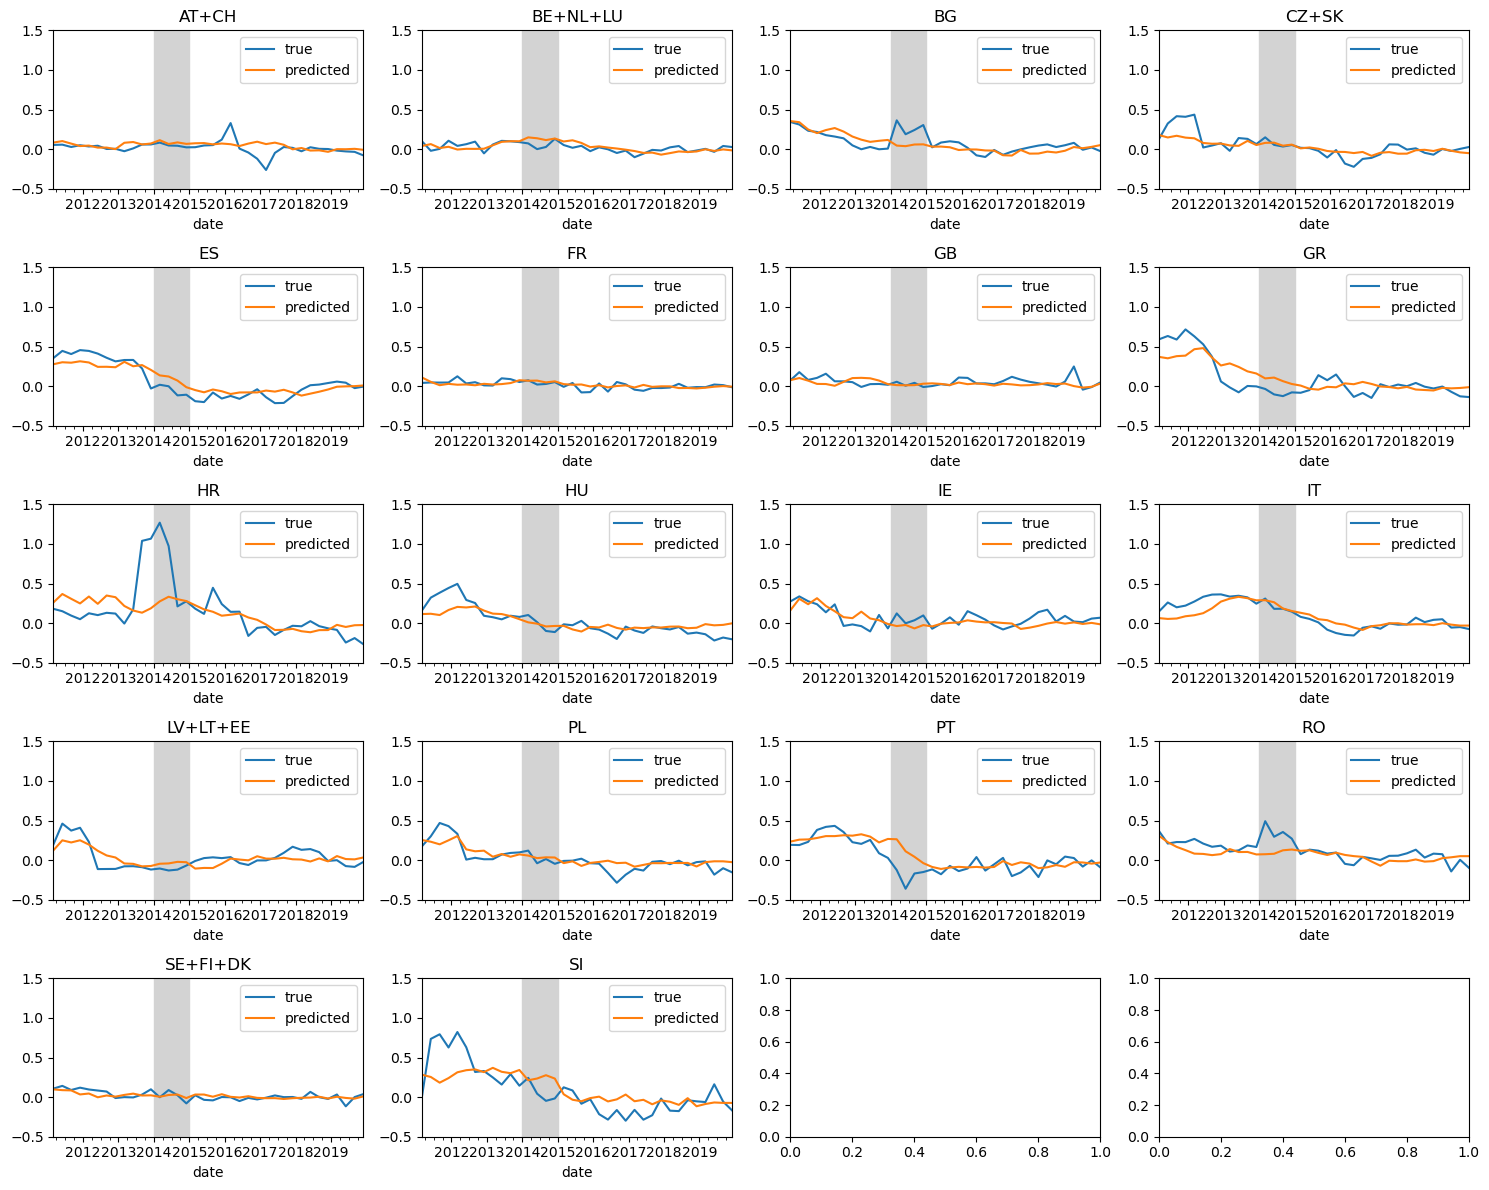

In [85]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


Without own lags

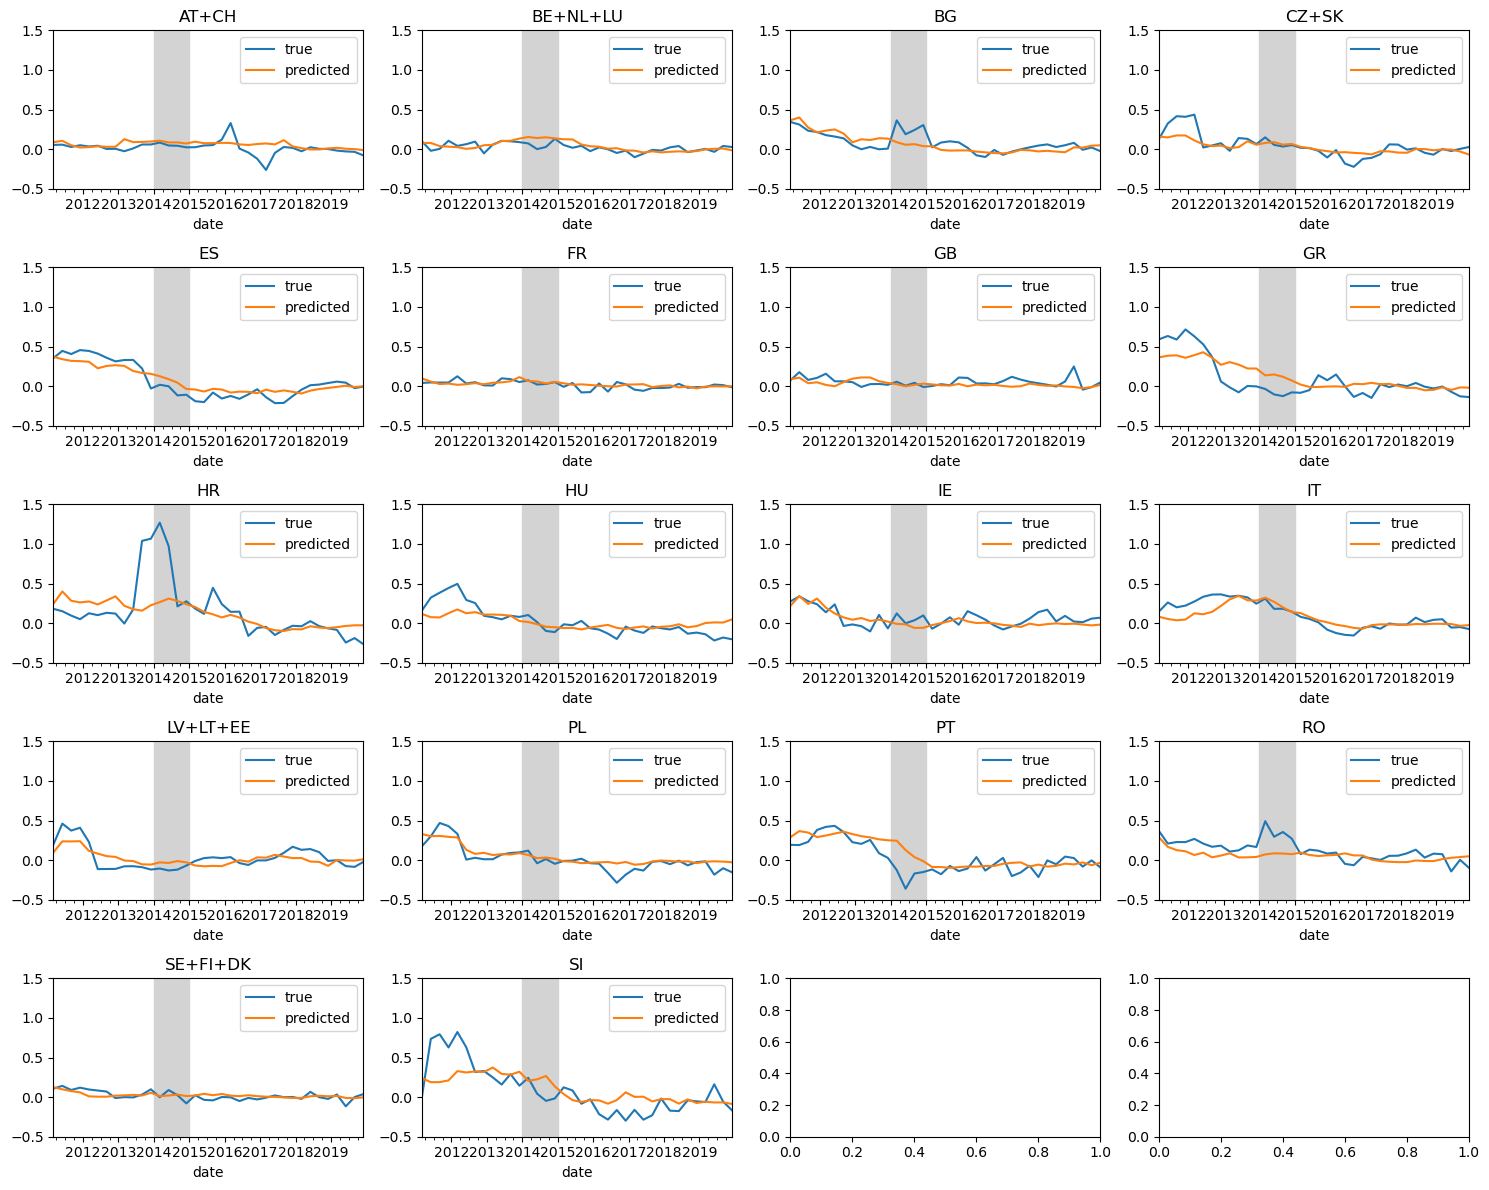

In [86]:
i = model_names.index("19+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

Without Google Trends

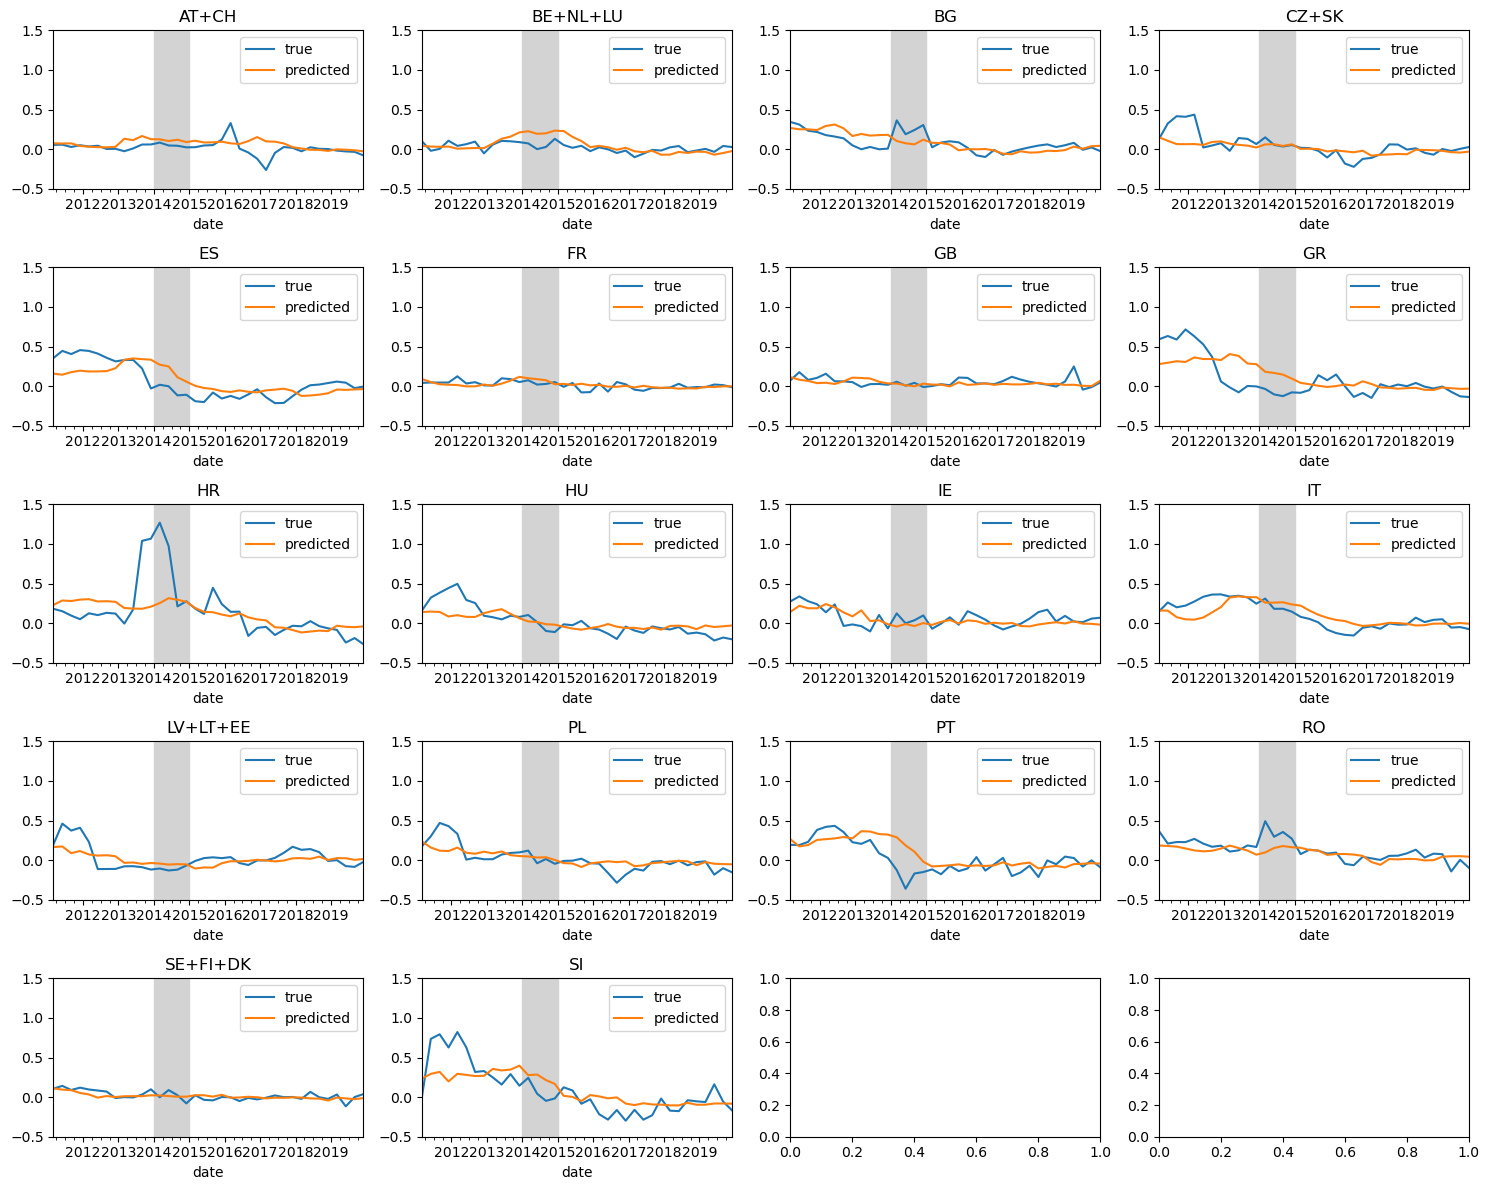

In [87]:
i = model_names.index("ar+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

Comparison

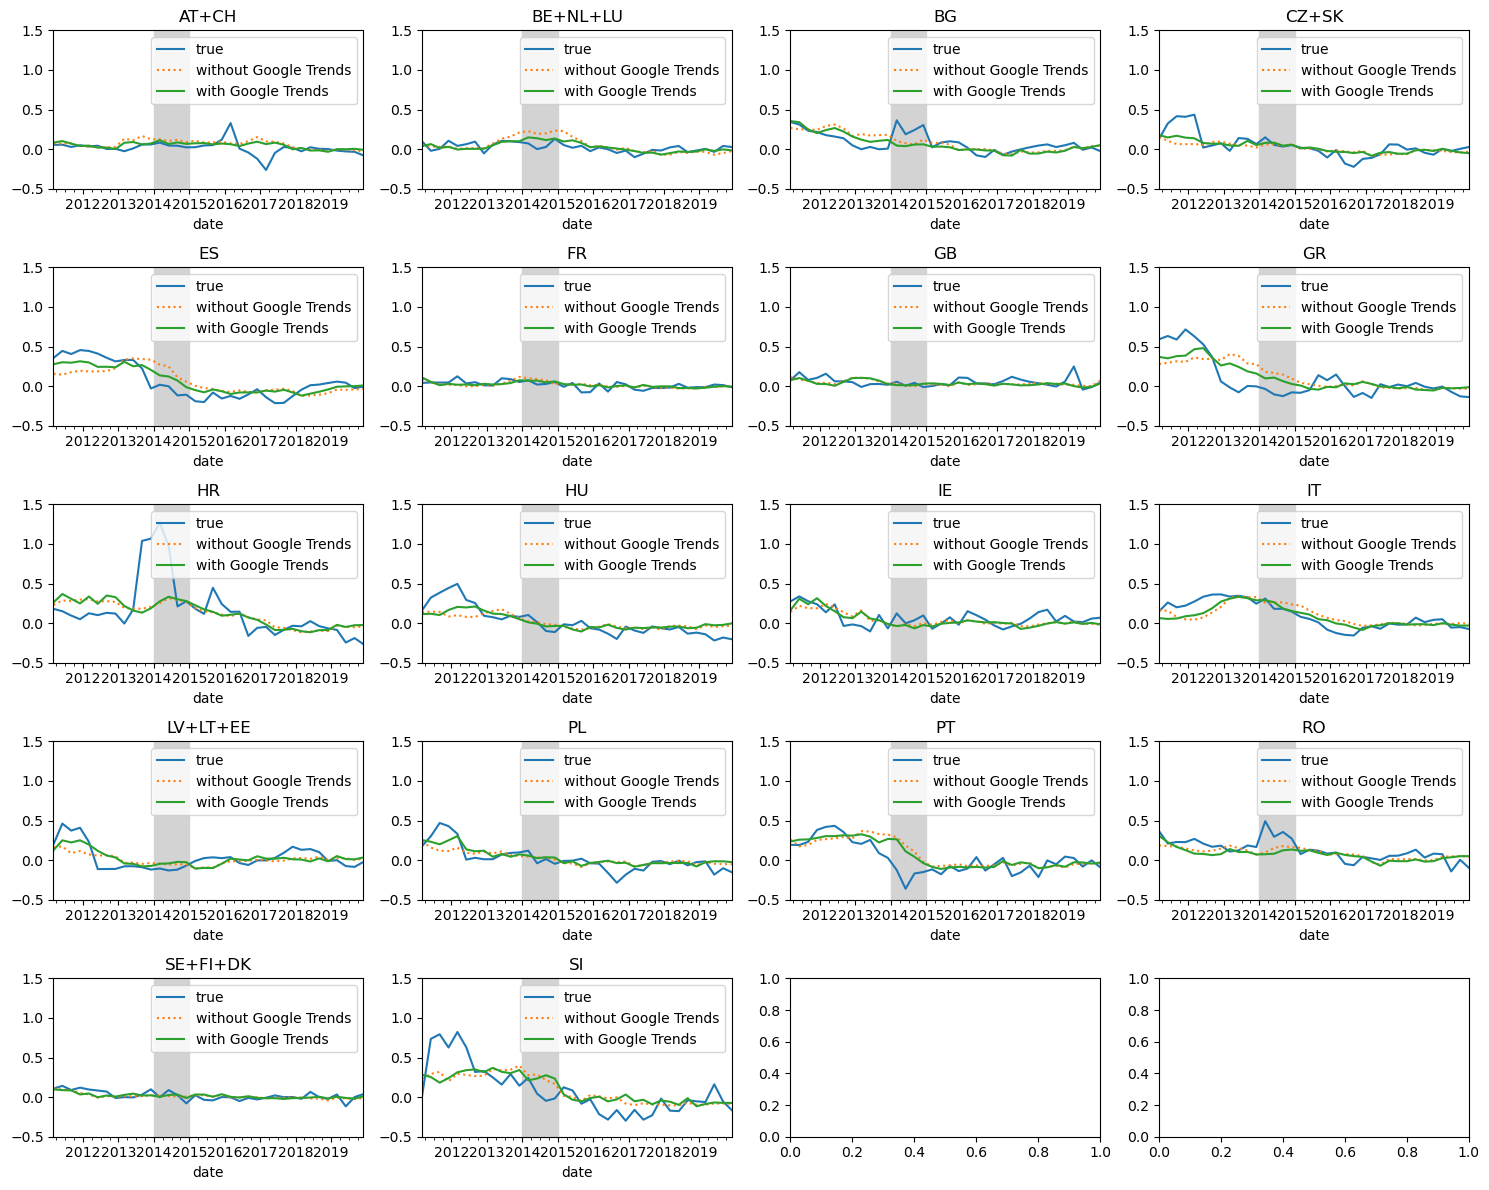

In [88]:
i1 = model_names.index("ar+gdp+unempl")
i2 = model_names.index("ar+19+gdp+unempl")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"without Google Trends": y_pred_i1, "with Google Trends": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
    style={"without Google Trends": ":"}
)
plt.show()

### monthly frequency with 3m rolling mean

In [89]:
### TRAINING

feature_combinations = [
    ["19"],
    ["value"],
    ["value", "19"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds = [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

panel_resampled = panel_comb.rolling("90D").mean()

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_resampled, columns=features, lags=[3, 6, 9, 12, 15, 18]
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_stackeds.append(train_stacked)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.LinearRegression(),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [90]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                  mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
['19']            0.004   2.517e-04  8.897e-05    0.005    7.262e-04  2.568e-04  -0.094   0.035  0.012   -0.135   0.053  0.019           0.127          0.181  0.064     0.237    0.307  0.108      0.028      0.039  0.014
['value']         0.003   3.536e-04  1.250e-04    0.004    4.661e-04  1.648e-04  -0.078   0.033  0.012   -0.112   0.046  0.016           0.339          0.354  0.125     0.465    0.250  0.088      0.045      0.056  0.020
['value', '19']   0.004   1.507e-04  5.326e-05    0.004    4.069e-04  1.439e-04  -0.071   0.020  0.007   -0.100   0.032  0.011           0.468          0.130  0.046     0.560    0.171  0.060      0.052      0.054  0.019

In [91]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod,delta_mae
['19'],-0.102,-0.184,0.394,0.437,0.041
['value'],-0.077,-0.117,0.744,0.774,0.067
"['value', '19']",-0.074,-0.113,0.757,0.787,0.070
